In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
import joblib

In [11]:
# Load the data into a DataFrame
data = pd.read_excel('DATA AR JANUARI - MEI 2023 - FIX - Copy.xlsx')
data.head()

,Nomor,AR_Type,Cust_Name,Segment,Bidang Baku,Tipe,Layanan,Bandwidth,Biaya_Sewa,Address_Terminating,SBU_Ter,AL_Status,Kabupaten/Kota,Wilayah
0,1,Change Tariff,DINAS KOMUNIKASI DAN INFORMATIKA STATISTIK DAN...,Government,NaN,NaN,Bronze,Units,190000.0,"(Kantor Kecamatan Singgahan) Jojogan, Mulyoagu...",SBU REG JAWA BAGIAN TIMUR,Active,Kabupaten,Tuban
1,2,Change Tariff,DINAS KOMUNIKASI DAN INFORMATIKA STATISTIK DAN...,Government,NaN,NaN,Bronze,Units,190000.0,(Kantor Kecamatan Plumpang) Jl. Raya Plumpang ...,SBU REG JAWA BAGIAN TIMUR,Active,Kabupaten,Tuban
2,3,Change Tariff,DINAS KOMUNIKASI DAN INFORMATIKA STATISTIK DAN...,Government,NaN,NaN,Bronze,Units,190000.0,(Kantor Kecamatan Parengan) Jl. Cokrokusumo No...,SBU REG JAWA BAGIAN TIMUR,Active,Kabupaten,Tuban
3,4,Change Tariff,DINAS KOMUNIKASI DAN INFORMATIKA STATISTIK DAN...,Government,NaN,NaN,Bronze,Units,190000.0,(Kantor Kecamatan Kerek) Jalan Raya Kresek No....,SBU REG JAWA BAGIAN TIMUR,Active,Kabupaten,Tuban
4,5,Change Tariff,DINAS KOMUNIKASI DAN INFORMATIKA STATISTIK DAN...,Government,NaN,NaN,Bronze,Units,190000.0,"(Kantor Kecamatan Kenduruan) Jl. Blora No. 01,...",SBU REG JAWA BAGIAN TIMUR,Active,Kabupaten,Tuban


In [12]:
# Feature Engineering
data = data[(data.Bandwidth != "Units") & (data.Layanan != "Penambahan IPv4 Publik Internet Corporate")]
data = data[data.AL_Status == "Active"]
data = data[data.SBU_Ter == "SBU REG JAWA BAGIAN TIMUR"]
data = data[data.AR_Type != "Trial"]
data = data.drop(['Nomor', 'Segment', 'Cust_Name', 'Address_Terminating', 'SBU_Ter', 'AL_Status'], axis=1)
data.head()

,AR_Type,Bidang Baku,Tipe,Layanan,Bandwidth,Biaya_Sewa,Kabupaten/Kota,Wilayah
216,Upgrade,"Administrasi Pemerintahan, Pertahanan Dan Jami...",Internet,Internet Broadband Corporate,50,552252.25,Kabupaten,Banyuwangi
217,New,"Administrasi Pemerintahan, Pertahanan Dan Jami...",Internet,Internet Broadband Corporate,50,0.00,Kabupaten,Banyuwangi
218,New,Pendidikan,Internet,Internet Broadband Corporate,100,1800000.00,Kabupaten,Blitar
219,New,"Administrasi Pemerintahan, Pertahanan Dan Jami...",Internet,Internet Broadband Corporate,20,520000.00,Kabupaten,Gresik
236,Change Tariff,"Administrasi Pemerintahan, Pertahanan Dan Jami...",Internet,Internet Broadband Corporate,50,2522522.52,Kabupaten,Gresik


In [13]:
# Preprocessing
encoder = OrdinalEncoder()
data["AR_Type"] = encoder.fit_transform(data[["AR_Type"]])
data["Bidang Baku"] = encoder.fit_transform(data[["Bidang Baku"]])
data["Tipe"] = encoder.fit_transform(data[["Tipe"]])
data["Layanan"] = encoder.fit_transform(data[["Layanan"]])
data["Bandwidth"] = data["Bandwidth"].astype(float)
data["Kabupaten/Kota"] = encoder.fit_transform(data[["Kabupaten/Kota"]])
data["Wilayah"] = encoder.fit_transform(data[["Wilayah"]])

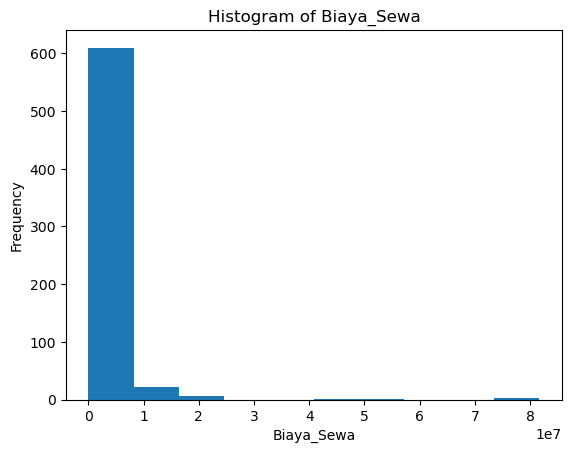

In [14]:
# Exploratory Data Analysis (EDA)
# Plot Histogram
plt.hist(data['Biaya_Sewa'], bins=10)
plt.xlabel('Biaya_Sewa')
plt.ylabel('Frequency')
plt.title('Histogram of Biaya_Sewa')
plt.show()

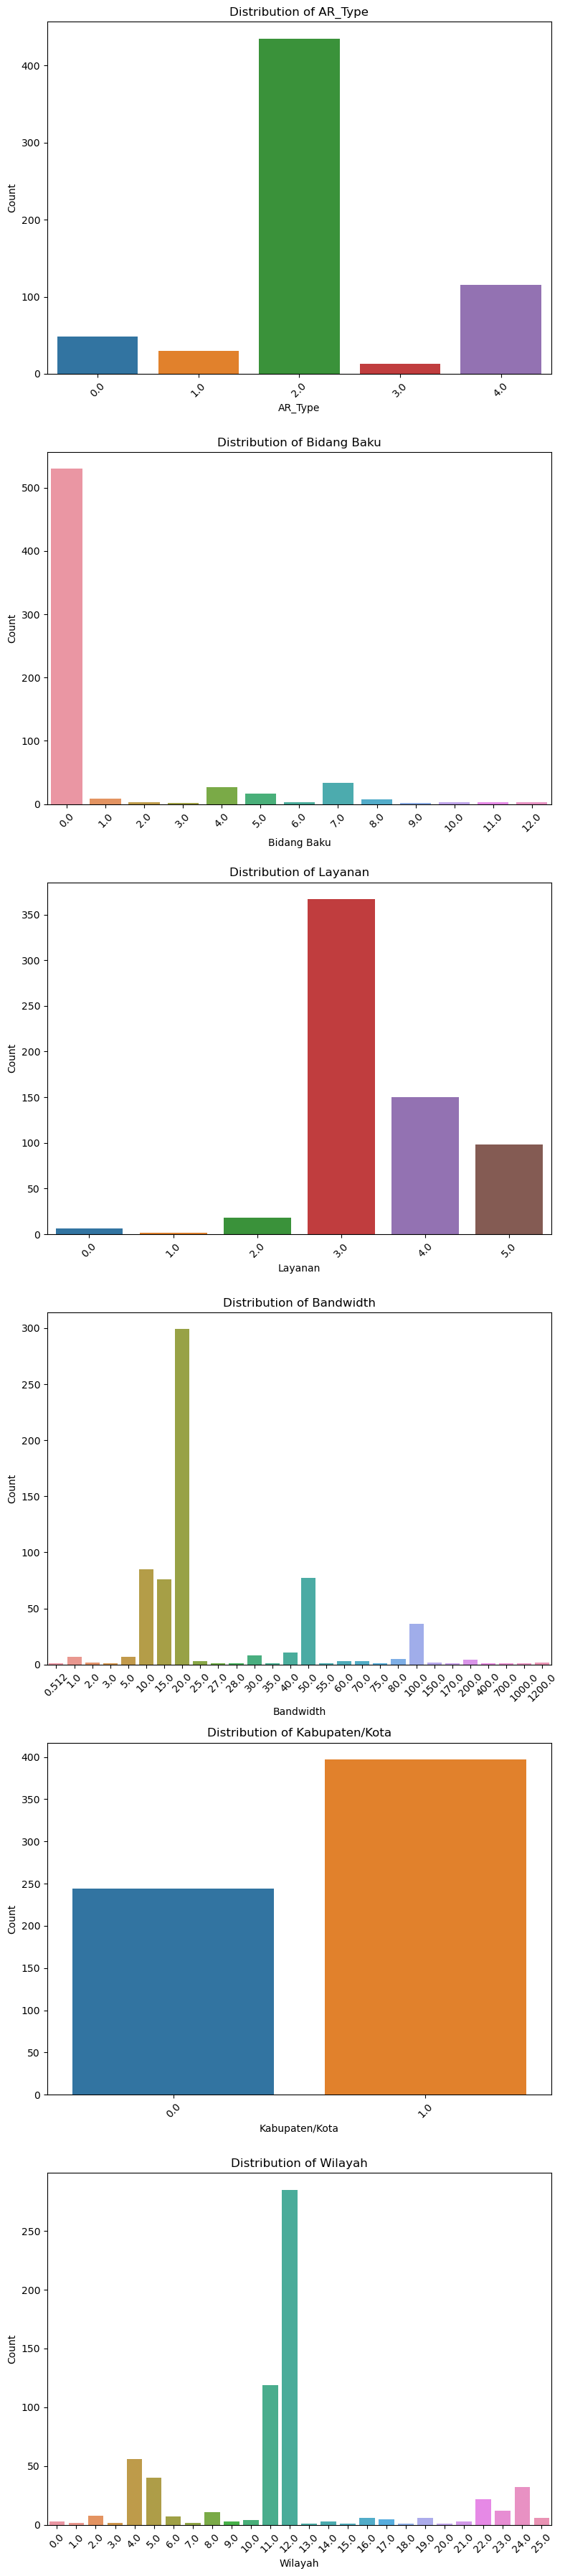

In [15]:
categorical_vars = ['AR_Type', 'Bidang Baku', 'Layanan', 'Bandwidth', 'Kabupaten/Kota', 'Wilayah']
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(8, 6 * len(categorical_vars)))
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, data=data, ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Descriptive Analysis
summary_stats = data.describe()
print(summary_stats)

          AR_Type  Bidang Baku        Tipe     Layanan    Bandwidth  \
count  641.000000   641.000000  641.000000  641.000000   641.000000   
mean     2.182527     0.993760    0.180967    3.477379    35.888474   
std      1.025948     2.409608    0.385292    0.862339    85.984786   
min      0.000000     0.000000    0.000000    0.000000     0.512000   
25%      2.000000     0.000000    0.000000    3.000000    15.000000   
50%      2.000000     0.000000    0.000000    3.000000    20.000000   
75%      2.000000     0.000000    0.000000    4.000000    25.000000   
max      4.000000    12.000000    1.000000    5.000000  1200.000000   

         Biaya_Sewa  Kabupaten/Kota     Wilayah  
count  6.410000e+02      641.000000  641.000000  
mean   2.157327e+06        0.619345   11.750390  
std    5.980578e+06        0.485927    5.293578  
min    0.000000e+00        0.000000    0.000000  
25%    2.972973e+05        0.000000   11.000000  
50%    8.000000e+05        1.000000   12.000000  
75%    1.7

In [22]:
# Split Data
X = data.drop('Layanan', axis=1)
y = data['Layanan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [23]:
# Multinomial Logistic Regression (Baseline Model)
transformer = ColumnTransformer(transformers=[('categorical', OrdinalEncoder(), categorical_vars)], remainder='passthrough')
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=20000)
baseline_model_pipe = make_pipeline(transformer, StandardScaler(with_mean=False), lr)
baseline_model_pipe.fit(X_train, y_train)
y_test_pred = baseline_model_pipe.predict(X_test)
y_train_pred = baseline_model_pipe.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print("Train Set Accuracy: {:.2f}%".format(train_accuracy))
print("Test Set Accuracy: {:.2f}%".format(test_accuracy))
print("\nConfusion Matrix:\n{}".format(confusion_matrix(y_test, y_test_pred)))
print("\nClassification Report:\n{}".format(classification_report(y_test, y_test_pred)))

ValueError: A given column is not a column of the dataframe

In [20]:
# Multinomial Logistic Regression with Upsampled Data
n_samples = min([len(X_train[y_train == i]) for i in range(199)])
n_neighbors = 5
if n_neighbors <= n_samples:
    oversampler = SMOTE(sampling_strategy='not majority', k_neighbors=n_neighbors)
else:
    oversampler = RandomOverSampler(sampling_strategy='not majority')
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), numerical_vars),
    ('categorical', OrdinalEncoder(), categorical_vars)
])
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)
X_train_preprocessed = preprocessor.fit_transform(X_train_oversampled)
X_test_preprocessed = preprocessor.transform(X_test)
lr.fit(X_train_preprocessed, y_train_oversampled)
y_test_pred = lr.predict(X_test_preprocessed)
y_train_pred = lr.predict(X_train_preprocessed)
train_accuracy = accuracy_score(y_train_oversampled, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print("Train Set Accuracy: {:.2f}%".format(train_accuracy))
print("Test Set Accuracy: {:.2f}%".format(test_accuracy))
print("\nConfusion Matrix:\n{}".format(confusion_matrix(y_test, y_test_pred)))
print("\nClassification Report:\n{}".format(classification_report(y_test, y_test_pred)))

NameError: name 'RandomOverSampler' is not defined

In [ ]:
# Save Models
joblib.dump(lr, 'lr_model.pkl')